In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import math

In [3]:
data=pd.read_csv('~\Downloads\daily_data.csv')
data

,datetime,high,low,close,open,volume
0,2018-01-01,13818.55,12750.00,13135.00,13715.65,6970.441076
1,2018-01-02,14750.00,12890.02,14580.00,13135.00,16359.347340
2,2018-01-03,15473.49,14150.00,14749.97,14576.87,19457.238601
3,2018-01-04,15280.00,13918.04,14811.00,14710.00,18783.876561
4,2018-01-05,17118.13,14600.00,16579.00,14805.01,22383.657333
...,...,...,...,...,...,...
1468,2022-01-08,42246.37,40501.00,40679.82,41707.04,27031.900870
1469,2022-01-09,42300.00,40520.00,41966.99,40679.82,27291.009660
1470,2022-01-10,42786.70,39650.00,41604.58,41966.99,51064.904360
1471,2022-01-11,43100.00,41158.99,42755.00,41604.58,38062.818280


In [4]:
def get_macd(price,slow,fast,smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1-exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    frames =  [macd, signal]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

macd=get_macd(data.close,26,12,9)
macd

,macd,signal
0,0.000000,0.000000
1,115.270655,23.054131
2,217.827657,62.008836
3,300.564708,109.720011
4,502.998982,188.375805
...,...,...
1468,-2136.672368,-1568.284564
1469,-2233.642180,-1701.356087
1470,-2313.071268,-1823.699123
1471,-2257.170852,-1910.393469


In [5]:
def generate_signal_for_macd(df,data):
    datetime=[]
    signal=[]
    current=0
    datetime.append(data.datetime[0])
    signal.append(0)
    for i in range(1,len(df.macd)):
        if(df.macd[i]>=df.signal[i] ):
            datetime.append(data.datetime[i])
            signal.append(1)
        elif(df.macd[i]<=df.signal[i]):
            datetime.append(data.datetime[i])
            signal.append(-1)
        else:
            datetime.append(data.datetime[i])
            signal.append(0)
    a=pd.DataFrame(columns=['datetime','signal'])
    a['datetime']=datetime
    a['signal']=signal
    return a
            
        
        
output=generate_signal_for_macd(macd,data)
output

,datetime,signal
0,2018-01-01,0
1,2018-01-02,1
2,2018-01-03,1
3,2018-01-04,1
4,2018-01-05,1
...,...,...
1468,2022-01-08,-1
1469,2022-01-09,-1
1470,2022-01-10,-1
1471,2022-01-11,-1


In [59]:
def to_submit(data,output):
    datetime=[]
    trade=[]
    signal=[]
    price=[]
    current=0
    for i in range(len(data.close)):
        if(i==(len(data.close)-1)):
            if(current==1):
                datetime.append(output.datetime[i])
#                 price.append(data.close[i])
                trade.append('close')
                signal.append(-1)
            elif(current==-1):
                datetime.append(output.datetime[i])
#                 price.append(data.close[i])
                trade.append('close')
                signal.append(1)
            else:
                break
            break
        if(output.signal[i]==1):
            if(current==1):
                datetime.append(output.datetime[i])
                trade.append('close')
#                 price.append(data.close[i])
                signal.append(0)
            elif(current==0):
                datetime.append(output.datetime[i])
#                 price.append(data.close[i])
                trade.append('close')
                signal.append(1)
                current=1
            else:
                datetime.append(output.datetime[i])
                trade.append('close')
#                 price.append(data.close[i])
                signal.append(1)
                current=0
            
        elif(output.signal[i]==-1):
            if(current==1):
                datetime.append(output.datetime[i])
                signal.append(-1)
#                 price.append(data.close[i])
                trade.append('close')
                current=0
            elif(current==0):
                datetime.append(output.datetime[i])
                trade.append('close')
#                 price.append(data.close[i])
                signal.append(-1)
                current=-1
            else:
                datetime.append(output.datetime[i])
                trade.append('close')
#                 price.append(data.close[i])
                signal.append(0)
                current=-1
        
        else:
            datetime.append(output.datetime[i])
            trade.append('close')
#             price.append(data.close[i])
            signal.append(0)
        
            
#     return signal        
    to_submit=pd.DataFrame(columns=['datetime'])
    to_submit['datetime']=datetime
    to_submit['open']=data.open
    
    to_submit['high']=data.high
    to_submit['low']=data.low
    to_submit['close']=data.close
    to_submit['volume']=data.volume
    
    to_submit['close\open']=trade
#     to_submit['price']=price
    to_submit['signal']=signal

    return to_submit
            
            

In [104]:
def trailing_stop_loss(data,submit):
    datetime=[]
    trade=[]
    signal=[]
    percent=0.05
    hello=0
    stop_loss=0
    current=0
    l=-1
    for i in range(len(submit.datetime)):
        datetime.append(submit.datetime[i])
        trade.append('cloase')
        if(i<=l):
            continue
        if(hello==0):
            if(submit.signal[i]==0):
                signal.append(0)
            elif(submit.signal[i]==1):
                hello=1
                current=data.close[i]
                stop_loss=((1-percent)*current)
                signal.append(1)
                
            else:
                hello=-1
                current=data.close[i]
                stop_loss=((1+percent)*current)
                signal.append(-1)          
                
        elif(hello==1):
            if(submit.signal[i]==-1):

                    hello=0
                    signal.append(-1)
                    stop_loss=0
                    
            elif(submit.signal[i]==0):
                if(data.close[i]>current):
                    current=data.close[i]
                    stop_loss=((1-percent)*current)
                    signal.append(0)
            
                    
                elif(data.close[i]<=stop_loss):
                    signal.append(-1)
                    stop_loss=0
                    hello=0
                    for j in range(i+1,len(submit.datetime)):
                        if(submit.signal[j]==-1):
                            signal.append(0)
                            l=j
                            break
                        signal.append(0)
                
                else:
                    signal.append(0)
                        
            
            
        else:#hello=-1
            if(submit.signal[i]==1):
                    signal.append(1)
                    stop_loss=0
                    hello=0
                    
            elif(submit.signal[i]==0):
                if(data.close[i]<current):
                    current=data.close[i]
                    stop_loss=((1+percent)*data.close[i])
                    signal.append(0)
                
                    
                elif(data.close[i]>=stop_loss):
                    signal.append(1)
                    stop_loss=0
                    hello=0
                    for j in range(i+1,len(submit.datetime)):
                        if(submit.signal[j]==1):
                            signal.append(0)
                            l=j
                            break
                        signal.append(0)   
                        
                else:
                    signal.append(0)
                
                
            
        
#     return signal   
    to_submit=pd.DataFrame(columns=['datetime'])
    to_submit['datetime']=datetime
    to_submit['open']=data.open
    
    to_submit['high']=data.high
    to_submit['low']=data.low
    to_submit['close']=data.close
    to_submit['volume']=data.volume
    
    to_submit['close\open']=trade
#     to_submit['price']=price
    to_submit['signal']=signal

    return to_submit 
            
            
    

In [129]:
def dd_long_short(trade_type,close):
    
    if trade_type == 'Long then short':
        cumulative_max_values = close.cummax()
        cumulative_returns = close/ cumulative_max_values - 1
        max_drawdown = cumulative_returns.min()
        return max_drawdown
        
    elif trade_type == 'Short then long':
        pip=[]
        for i in close:
            pip.append(i)
        stock = -(1000 /pip[0])
        portfolio = []

        for i in range(len(pip)):
            profit = stock * (pip[i] - pip[0])
            portfolio.append(1000+profit)
        
        drawdown = []
        new = 0

        for i in range(len(portfolio)):
            new = max(new,portfolio[i])
            drawdown.append(((new-portfolio[i])/new))
            
        return np.max(drawdown)

def metrics(data,submit):
    capital=1000
    current=0
    temp=0
    portfolio_value=[]
    datetime=[]
    quantity=[]
    
    sharpe=[]
    returns=[]
    risk_free_rate=0.05       
    for i in range(len(data.close)):
        datetime.append(data.datetime[i])
        if(submit.signal[i]==1):
            if(current==0):
                portfolio_value.append(capital)
                returns.append((capital-1000)/10)
                sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))
                
                temp=capital/(data.close[i])
                quantity.append(temp)
                capital=0
                current=1
            else:
                capital=capital-(temp*data.close[i])
                returns.append((capital-1000)/10)
                sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))
                quantity.append(temp)
                portfolio_value.append(capital)
                temp=0
                current=0
                
        elif(submit.signal[i]==-1):
            if(current==0):
                portfolio_value.append(capital)
                temp=capital/(data.close[i])
                quantity.append(temp)
                returns.append((capital-1000)/10)
                sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))
                capital=capital+(temp*data.close[i])
                
                current=-1
            else:
                capital=capital+(temp*data.close[i])
                quantity.append(temp)
                current=0
                temp=0
                portfolio_value.append(capital)
                returns.append((capital-1000)/10)
                sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))
        
        else:
            if(current==0):
                portfolio_value.append(capital)
                quantity.append(temp)
                returns.append((capital-1000)/10)
                sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))
            elif(current==1):
                portfolio_value.append(capital+(temp*data.close[i]))
                quantity.append(temp)
                returns.append((capital+(temp*data.close[i])-1000)/10)
                sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))
            else:
                portfolio_value.append(capital-(temp*data.close[i]))
                quantity.append(temp)
                returns.append((capital-(temp*data.close[i])-1000)/10)
                sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))
                
    a=pd.DataFrame(columns=['datetime','portfolio value'])
    a['datetime']=datetime
    a['portfolio value']=portfolio_value
#     a['sharpe']=sharpe
    a['quantity']=quantity
    
#     a['daily_return'] = a['portfolio value'].pct_change()
#     daily_volatility = a['daily_return'].std()
#     annual_volatility = daily_volatility * math.sqrt(252)
#     risk_free_rate = 0.03
    
#     a['excess_return'] = a['daily_return'] - risk_free_rate / 252
#     cumulative_excess_return = a['excess_return'].sum()
#     negative_returns = [r for r in a['excess_return'] if r < 0]
#     cumulative_volatility = a['daily_return'].std() * math.sqrt(252)
#     hello=np.std(negative_returns)*math.sqrt(252)
#     sharpe_ratio = cumulative_excess_return / cumulative_volatility
#     sortino_ratio=cumulative_excess_return / hello

    a=pd.DataFrame(columns=['datetime','portfolio value'])
    a['datetime']=datetime
    a['portfolio value']=portfolio_value
    a['quantity']=quantity
    a['daily_return'] = a['portfolio value'].pct_change()
    daily_volatility = a['daily_return'].std()
    annual_volatility = daily_volatility * math.sqrt(365)
    annual_volatility_negative = a[a['daily_return'] < 0]['daily_return'].std() * math.sqrt(365)
    risk_free_rate = 0.05
    a['excess_return'] = (a['daily_return'] - risk_free_rate)
    annual_excess_return = (a['daily_return'].mean()*365 - risk_free_rate)
    cumulative_excess_return = a['excess_return'].sum()
    negative_returns = [r for r in a['excess_return'] if r < 0]
    cumulative_volatility = a['daily_return'].std()*math.sqrt(252)
    hello=np.std(negative_returns)*math.sqrt(252)
    sharpe_ratio = annual_excess_return / annual_volatility
    sortino_ratio = annual_excess_return / annual_volatility_negative
    
    
    trade_type=[]
    start=[]
    end=[]
    start_value=[]
    end_value=[]
    duration=[]
    P_and_L=[]
    return_for_every_trade=[]
    pointer=0
    drawdown=[]
    for i in range(len(submit.signal)):
        if(submit.signal[i]==1):
            if(pointer==0):
                trade_type.append('long')
                start.append(i)
                start_value.append(portfolio_value[i])
                pointer=1
            else:
                end.append(i)
                end_value.append(portfolio_value[i])
                return_for_every_trade.append(100*((end_value[-1]/start_value[-1])-1))
                P_and_L.append(end_value[-1]-start_value[-1])
                duration.append(end[-1]-start[-1])
                pointer=0
                
                drawdown.append(dd_long_short('Short then long',data.close[start[-1]:end[-1]]))
#                 drawdown.append(100*((portfolio_value[start[-1]]/minimum)-1))
                
        elif(submit.signal[i]==-1):
            if(pointer==0):
                trade_type.append('short')
                start.append(i)
                start_value.append(portfolio_value[i])
                pointer=-1
            else:
                end.append(i)
                end_value.append(portfolio_value[i])
                return_for_every_trade.append(100*((end_value[-1]/start_value[-1])-1))
                P_and_L.append(end_value[-1]-start_value[-1])
                duration.append(end[-1]-start[-1])
                pointer=0
                
                drawdown.append(dd_long_short('Long then short',data.close[start[-1]:end[-1]]))
                
    b=pd.DataFrame(columns=['start','end'])
    b['start']=start
    b['end']=end
    b['duration']=duration
    b['return for every trade']=return_for_every_trade
    b['P and L']=P_and_L
    b['drawdown']=drawdown
    b['trade type']=trade_type
    

    gross_profit=[]
    gross_loss=[]
    for i in range(len(P_and_L)):
        if(P_and_L[i]>0):
            gross_profit.append(P_and_L[i])
        else:
            gross_loss.append(P_and_L[i])
    print("GROSS PROFIT: ",np.sum(gross_profit))
    print("GROSS LOSS: ",np.sum(gross_loss))
    print("NET P and L: ",np.sum(P_and_L))
    print("TOTAL CLOSED TRADES: ",len(start))
    print("WIN RATE: ",100*(len(gross_profit)/(len(gross_profit)+len(gross_loss))))
    print("AVG WINNING TRADE: ",np.mean(gross_profit))
    print("AVG LOSING TRADE: ",np.mean(gross_loss))
    print("Largest Losing trade: ",min(gross_loss))
    print("Largest winning trade: ",max(gross_profit))
    print("Avg holding duration: ",np.mean(duration))
    
   
    
    print("Sharpe Ratio: ",sharpe_ratio)


#     std_dev_negative = np.std(negative_returns)
            
    print("Sortino Ratio: ",sortino_ratio)
    print("RETURNS: ",((np.sum(P_and_L))/10))
    print("MAX Drawdown: (in %) ",100*np.min(drawdown))
    plt.plot(portfolio_value)
    return a,b
                

C:\Users\tanus\AppData\Local\Temp\ipykernel_14500\4223755451.py:85: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))
C:\Users\tanus\AppData\Local\Temp\ipykernel_14500\4223755451.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))


GROSS PROFIT:  26592.906476222706
GROSS LOSS:  -14492.786940878219
NET P and L:  12100.119535344496
TOTAL CLOSED TRADES:  90
WIN RATE:  43.333333333333336
AVG WINNING TRADE:  681.8693968262232
AVG LOSING TRADE:  -284.17229295839644
Largest Losing trade:  -1606.0446297717535
Largest winning trade:  2909.883711403785
Avg holding duration:  15.355555555555556
Sharpe Ratio:  1.192519768521198
Sortino Ratio:  1.7646046236007729
RETURNS:  1210.0119535344497
MAX Drawdown: (in %)  -19.896452669999356


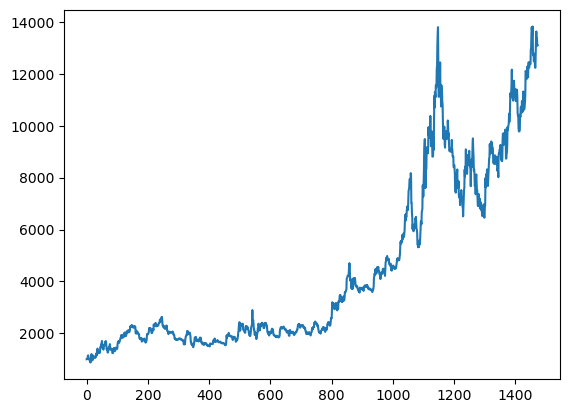

In [133]:
daily_metrics,only_trade=metrics(data,to_submit(data,output))

In [134]:
daily_metrics

,datetime,portfolio value,quantity,daily_return,excess_return
0,2018-01-01,1000.000000,0.000000,NaN,NaN
1,2018-01-02,1000.000000,0.068587,0.000000,-0.050000
2,2018-01-03,1011.657750,0.068587,0.011658,-0.038342
3,2018-01-04,1015.843621,0.068587,0.004138,-0.045862
4,2018-01-05,1137.105624,0.068587,0.119371,0.069371
...,...,...,...,...,...
1468,2022-01-08,13631.741249,0.266453,0.020502,-0.029498
1469,2022-01-09,13288.770930,0.266453,-0.025160,-0.075160
1470,2022-01-10,13385.336165,0.266453,0.007267,-0.042733
1471,2022-01-11,13078.803295,0.266453,-0.022901,-0.072901


In [135]:
only_trade

,start,end,duration,return for every trade,P and L,drawdown,trade type
0,1,10,9,-6.299726,-62.997257,-0.132474,long
1,11,28,17,15.115387,141.631594,0.197255,short
2,29,41,12,17.475647,188.498331,0.125885,short
3,42,66,24,7.396802,93.727294,-0.195108,long
4,67,81,14,3.064886,41.708812,0.139377,short
...,...,...,...,...,...,...,...
85,1393,1408,15,-5.375883,-589.727841,0.106379,short
86,1409,1411,2,-5.782988,-600.282906,-0.044943,long
87,1412,1448,36,26.527173,2594.322638,0.061349,short
88,1449,1464,15,-1.120804,-138.690405,-0.100946,long


In [136]:

def only_long_then_short(data,output):
    datetime=[]
    signal=[]
    trade=[]
    price=[]
    current=0
    for i in range(len(data.close)):
        datetime.append(data.datetime[i])
        trade.append('close')
#         price.append(data.close[i])
        if(i==len(data.close)-1):
            if(current==1):
                signal.append(-1)
                break
            else:
                signal.append(0)
                break
            
        
        if(output.signal[i]==1):
            if(current==0):
                signal.append(1)
                current=1
            else:
                signal.append(0)
        elif(output.signal[i]==-1):
            if(current==1):
                signal.append(-1)
                current=0
            else:
                signal.append(0)
            
        else:
            if(current==0):
                signal.append(0)
            else:
                signal.append(0)
    a=pd.DataFrame(columns=['datetime'])
    a['datetime']=datetime
    
    a['open']=data.open
    a['high']=data.high
    a['low']=data.low
    a['close']=data.close
    a['volume']=data.volume
    a['close\open']=trade
#     to_submit['price']=price
    a['signal']=signal
    
    
    return a
            

C:\Users\tanus\AppData\Local\Temp\ipykernel_14500\4223755451.py:85: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))
C:\Users\tanus\AppData\Local\Temp\ipykernel_14500\4223755451.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))


GROSS PROFIT:  11277.36164167483
GROSS LOSS:  -4386.708268218562
NET P and L:  6890.653373456266
TOTAL CLOSED TRADES:  47
WIN RATE:  40.42553191489361
AVG WINNING TRADE:  593.5453495618332
AVG LOSING TRADE:  -156.6681524363772
Largest Losing trade:  -815.5890862220385
Largest winning trade:  2389.7950593078467
Avg holding duration:  16.340425531914892
Sharpe Ratio:  1.136939490726401
Sortino Ratio:  1.1624627059502555
RETURNS:  689.0653373456266
MAX Drawdown: (in %)  -19.896452669999356


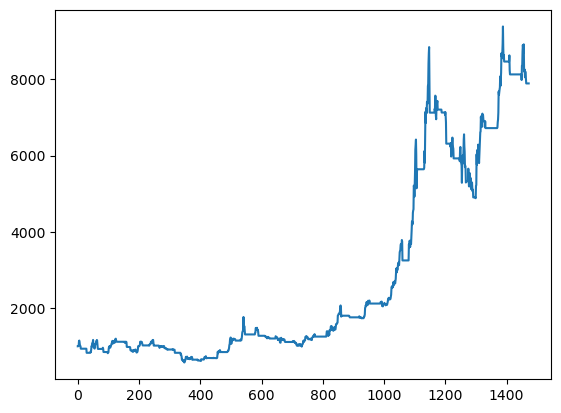

In [137]:
only_long_then_short_daily,only_long_then_short_trade=metrics(data,only_long_then_short(data,output))

In [138]:
only_long_then_short_daily,

(        datetime  portfolio value  quantity  daily_return  excess_return
 0     2018-01-01      1000.000000  0.000000           NaN            NaN
 1     2018-01-02      1000.000000  0.068587      0.000000      -0.050000
 2     2018-01-03      1011.657750  0.068587      0.011658      -0.038342
 3     2018-01-04      1015.843621  0.068587      0.004138      -0.045862
 4     2018-01-05      1137.105624  0.068587      0.119371       0.069371
 ...          ...              ...       ...           ...            ...
 1468  2022-01-08      7890.653373  0.000000      0.000000      -0.050000
 1469  2022-01-09      7890.653373  0.000000      0.000000      -0.050000
 1470  2022-01-10      7890.653373  0.000000      0.000000      -0.050000
 1471  2022-01-11      7890.653373  0.000000      0.000000      -0.050000
 1472  2022-01-12      7890.653373  0.000000      0.000000      -0.050000
 
 [1473 rows x 5 columns],)

In [139]:
only_long_then_short_trade

,start,end,duration,return for every trade,P and L,drawdown,trade type
0,1,10,9,-6.299726,-62.997257,-0.132474,long
1,28,29,1,-11.470496,-107.478859,0.000000,long
2,41,66,25,12.201368,101.213263,-0.195108,long
3,81,85,4,-8.721864,-81.177630,-0.115860,long
4,97,127,30,31.671617,269.069234,-0.060132,long
5,153,161,8,-12.212555,-136.613155,-0.121725,long
6,170,173,3,-9.433962,-92.642981,-0.080583,long
7,178,179,1,-3.662439,-32.572726,0.000000,long
8,180,212,32,19.409105,166.297190,-0.086749,long
9,232,249,17,-0.509922,-5.217002,-0.126860,long


In [14]:
to_submit(data,output).to_csv(r'C:\Users\tanus\Downloads\to_submit.csv')

C:\Users\tanus\AppData\Local\Temp\ipykernel_14500\4223755451.py:85: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))
C:\Users\tanus\AppData\Local\Temp\ipykernel_14500\4223755451.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))


GROSS PROFIT:  5686.378252398481
GROSS LOSS:  -4156.518410279805
NET P and L:  1529.8598421186762
TOTAL CLOSED TRADES:  90
WIN RATE:  42.22222222222222
AVG WINNING TRADE:  149.64153295785476
AVG LOSING TRADE:  -79.93304635153471
Largest Losing trade:  -220.25936622958625
Largest winning trade:  522.3413791682599
Avg holding duration:  7.288888888888889
Sharpe Ratio:  0.6164661090272265
Sortino Ratio:  0.6389836389186051
RETURNS:  152.98598421186762
MAX Drawdown: (in %)  -4.928097735587366


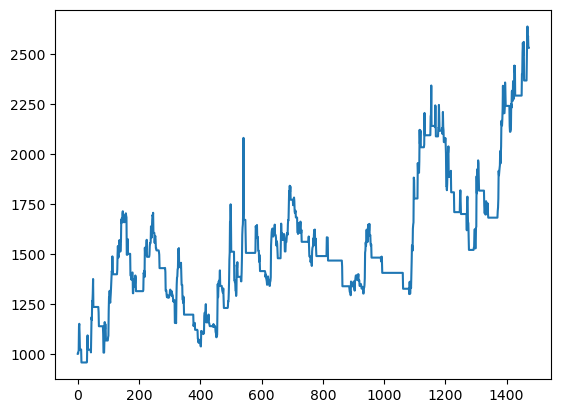

In [140]:
dm,ot=metrics(data,trailing_stop_loss(data,to_submit(data,output)))

In [141]:
dm

,datetime,portfolio value,quantity,daily_return,excess_return
0,2018-01-01,1000.000000,0.000000,NaN,NaN
1,2018-01-02,1000.000000,0.068587,0.000000,-0.050000
2,2018-01-03,1011.657750,0.068587,0.011658,-0.038342
3,2018-01-04,1015.843621,0.068587,0.004138,-0.045862
4,2018-01-05,1137.105624,0.068587,0.119371,0.069371
...,...,...,...,...,...
1468,2022-01-08,2636.815769,0.051541,0.020502,-0.029498
1469,2022-01-09,2570.474314,0.051541,-0.025160,-0.075160
1470,2022-01-10,2589.153126,0.051541,0.007267,-0.042733
1471,2022-01-11,2529.859842,0.051541,-0.022901,-0.072901


In [142]:
ot

,start,end,duration,return for every trade,P and L,drawdown,trade type
0,1,7,6,2.194787,21.947874,-0.044761,long
1,11,12,1,-6.371295,-65.111319,0.000000,short
2,29,33,4,6.698472,64.093428,0.000000,short
3,42,51,9,20.906734,213.443113,-0.013304,long
4,67,69,2,-7.806966,-96.367094,0.020842,short
...,...,...,...,...,...,...,...
85,1393,1397,4,1.657095,36.510062,0.020681,short
86,1409,1411,2,-5.782988,-129.525488,-0.044943,long
87,1412,1428,16,8.578150,181.019734,0.037254,short
88,1449,1457,8,3.294093,75.476292,-0.024213,long


C:\Users\tanus\AppData\Local\Temp\ipykernel_14500\4223755451.py:85: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))
C:\Users\tanus\AppData\Local\Temp\ipykernel_14500\4223755451.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe.append((np.mean(returns)-risk_free_rate)/(np.std(returns)))


GROSS PROFIT:  4276.214275314079
GROSS LOSS:  -2025.4766893283472
NET P and L:  2250.7375859857316
TOTAL CLOSED TRADES:  47
WIN RATE:  40.42553191489361
AVG WINNING TRADE:  225.06390922705677
AVG LOSING TRADE:  -72.33845319029811
Largest Losing trade:  -313.9202881172537
Largest winning trade:  923.7027904467254
Avg holding duration:  8.340425531914894
Sharpe Ratio:  0.8167062342326311
Sortino Ratio:  0.6292411558241703
RETURNS:  225.07375859857316
MAX Drawdown: (in %)  -4.928097735587366


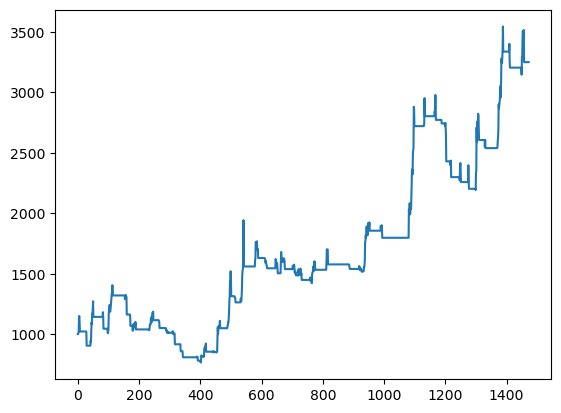

In [143]:
dm1,ot1=metrics(data,trailing_stop_loss(data,only_long_then_short(data,output)))

In [144]:
dm1

,datetime,portfolio value,quantity,daily_return,excess_return
0,2018-01-01,1000.000000,0.000000,NaN,NaN
1,2018-01-02,1000.000000,0.068587,0.000000,-0.050000
2,2018-01-03,1011.657750,0.068587,0.011658,-0.038342
3,2018-01-04,1015.843621,0.068587,0.004138,-0.045862
4,2018-01-05,1137.105624,0.068587,0.119371,0.069371
...,...,...,...,...,...
1468,2022-01-08,3250.737586,0.000000,0.000000,-0.050000
1469,2022-01-09,3250.737586,0.000000,0.000000,-0.050000
1470,2022-01-10,3250.737586,0.000000,0.000000,-0.050000
1471,2022-01-11,3250.737586,0.000000,0.000000,-0.050000


In [145]:
ot1

,start,end,duration,return for every trade,P and L,drawdown,trade type
0,1,7,6,2.194787,21.947874,-0.044761,long
1,28,29,1,-11.470496,-117.222487,0.000000,long
2,41,51,10,26.315688,238.084712,-0.013304,long
3,81,84,3,-8.571203,-97.952576,-0.034269,long
4,97,115,18,26.358609,275.409910,-0.045169,long
5,153,160,7,-11.952852,-157.809616,-0.023444,long
6,170,172,2,-8.058306,-93.674403,-0.008953,long
7,178,179,1,-3.662439,-39.143537,0.000000,long
8,180,190,10,0.921077,9.483774,-0.027459,long
9,232,247,15,7.343101,76.303897,-0.034717,long
